# projet Taxi Driver
La société Chapeau Bleu, société New Yorkaise de livraison spécialisée dans le transport d'urgence de denrées alimentaires pour personnes âgées (pots de beurre, galettes etc...), souhaite prédire le coût de déplacement de ses livreurs indépendants afin de pouvoir ajuster ses prix et améliorer ses marges.

### Critères de performance :
Le résultat final doit pouvoir mettre en évidence le placement de l'algorithme XGBoost par rapport à d'autres algorithmes qui peuvent répondre à la problématique de la société.
L'analyse et le choix des différents algorithmes autres que XGBoost devra être motivé.


In [75]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from classes import *
from classes.functions import Functions as fc
from credentials import Credentials as cr

timer = MyTimer()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## I. Split des données et récupération en DataFrames
Pour travailler sur des plus petits échantillons de données et avoir des réponses plus rapides au vu des capacités limitées de nos machines (et de leurs propriétaires). 

In [2]:
# Split des données sur l'année
# fc.split_datas_keys(cr.DATA_TRAIN, 'train')
# fc.split_datas_keys(cr.DATA_TEST, 'test')

In [35]:
# Import en DF des données splittées : on s'intéresse aux données de 2015
train_set = pd.read_csv(cr.CURATED_TRAIN + "2015.csv", sep=",")
test_set = pd.read_csv(cr.CURATED_TEST + "2015.csv", sep=",")

## II. Nettoyage des jeux de données 
Suppression des informations inutiles et filtrage des données erronées, anomalies et valeurs disparates pour améliorer les performances des futurs modèles. Valorisation de la data, en bref. 

In [3]:
print("-------- TRAIN_SET -------")
train_set.info()
print("\n\n-------- TEST_SET -------")
test_set.info()

-------- TRAIN_SET -------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3856809 entries, 0 to 3856808
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   fare_amount        float64
 2   pickup_datetime    object 
 3   pickup_longitude   float64
 4   pickup_latitude    float64
 5   dropoff_longitude  float64
 6   dropoff_latitude   float64
 7   passenger_count    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 235.4+ MB


-------- TEST_SET -------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619 entries, 0 to 618
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                619 non-null    object 
 1   pickup_datetime    619 non-null    object 
 2   pickup_longitude   619 non-null    float64
 3   pickup_latitude    619 non-null    float64
 4   dropoff_longitude  619 non-null    float64
 5   drop

### II. 1. Premier filtrage "manuel".

In [3]:
# Premières vérifications des valeurs : 
nancount = test_set['passenger_count'].isna()
print("Nombre de lignes 'passenger_count' nulles dans le dataset de test : ", nancount.sum())
nancount = train_set['passenger_count'].isna()
print("Nombre de lignes 'passenger_count' nulles dans le dataset de train : ", nancount.sum())
num_nuls = test_set[test_set['passenger_count']<=0]
print('Nombre de trajets avec 0 passagers dans le dataset test : ', len(num_nuls))
num_nuls = train_set[train_set['passenger_count']<=0]
print('Nombre de trajets avec 0 passagers dans le dataset train : ', len(num_nuls))
num_nuls = train_set[train_set['fare_amount']<=0]
print('Nombre de trajets avec "fare_amount" <= 0 dans le dataset train : ', len(num_nuls))

Nombre de lignes 'passenger_count' nulles dans le dataset de test :  0
Nombre de lignes 'passenger_count' nulles dans le dataset de train :  0
Nombre de trajets avec 0 passagers dans le dataset test :  0
Nombre de trajets avec 0 passagers dans le dataset train :  1802
Nombre de trajets avec "fare_amount" <= 0 dans le dataset train :  2231


In [36]:
# Filtrage sur le nombre de passagers
filtered_train_set = train_set[train_set['passenger_count']>=1]
filtered_train_set = train_set[train_set['fare_amount']>=1]

array([[<AxesSubplot:title={'center':'passenger_count'}>]], dtype=object)

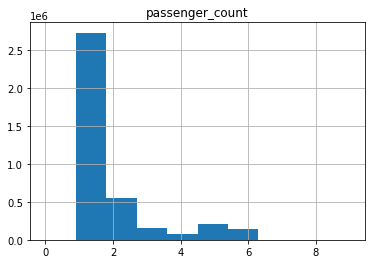

In [4]:
filtered_train_set.hist(column='passenger_count')

### II. 2. Calcul de la distance parcourue (Km) en fonction des informations de latitudes et longitudes avec la fonction compute_distance, et suppression de ces colonnes.

In [37]:
# Ajout colonne distance parcourue en Km avec la fonction compute_distance
filtered_train_set = filtered_train_set.assign(distance_km=fc.compute_distance(filtered_train_set['pickup_latitude'], filtered_train_set['pickup_longitude'], filtered_train_set['dropoff_latitude'], filtered_train_set['dropoff_longitude']))

In [38]:
# Sélection des colonnes qui intéressent et reformatage de la distance (stressant)
filtered_train_set = filtered_train_set[['passenger_count', 'distance_km', 'fare_amount']]
filtered_train_set.distance_km = filtered_train_set.distance_km.map('{:.2f}'.format)

In [7]:
filtered_train_set.head()

,passenger_count,distance_km,fare_amount
0,1,6.71,22.54
1,1,12.79,58.00
2,1,0.81,4.50
3,6,3.38,11.50
4,1,0.84,5.00


In [8]:
# Sauvegarde du premier DF filtré
filtered_train_set.to_csv(cr.CURATED_PATH + 'filtered_train_set.csv')

### II. 3. Isolation Forest pour déterminer et erradiquer les anomalies.

In [21]:
# Isolation Forest pour détecter les anomalies
fc.isolation_forest(cr.CURATED_PATH + 'filtered_train_set.csv', cr.CURATED_PATH + 'IFScore.csv')

   Unnamed: 0  passenger_count  distance_km  fare_amount    scores  anomaly
0           0                1         6.71        22.54 -0.007230       -1
1           1                1        12.79        58.00 -0.082405       -1
2           2                1         0.81         4.50  0.046305        1
3           3                6         3.38        11.50 -0.006841       -1
4           4                1         0.84         5.00  0.052302        1
5           5                2         0.59         5.00  0.015541        1
6           6                2         1.99        11.00  0.044893        1
7           7                1         3.50        14.00  0.028639        1
8           8                3         6.37        16.50 -0.032511       -1
9           9                1         2.90         9.00  0.063852        1


In [39]:
# Import du CSV avec le score de l'IF
filtered_train_set_with_IF = pd.read_csv(cr.CURATED_PATH + 'IFScore.csv', usecols=['passenger_count', 'distance_km', 'fare_amount', 'scores', 'anomaly'])
filtered_train_set_with_IF.head()

,passenger_count,distance_km,fare_amount,scores,anomaly
0,1,6.71,22.54,-0.007230,-1
1,1,12.79,58.00,-0.082405,-1
2,1,0.81,4.50,0.046305,1
3,6,3.38,11.50,-0.006841,-1
4,1,0.84,5.00,0.052302,1


In [61]:
# Vérification du nombre de valeurs
print("filtered_train_set_with_IF ", len(filtered_train_set_with_IF), " rows")
print("Anomalies ", len(filtered_train_set_with_IF[filtered_train_set_with_IF['anomaly']==-1]), " rows")

filtered_train_set_with_IF  3854148  rows
Anomalies  805757  rows


In [40]:
# Suppression des anomalies
filtered_train_set_with_IF = filtered_train_set_with_IF[['passenger_count', 'distance_km', 'fare_amount']][filtered_train_set_with_IF["anomaly"] != -1]

<AxesSubplot:>

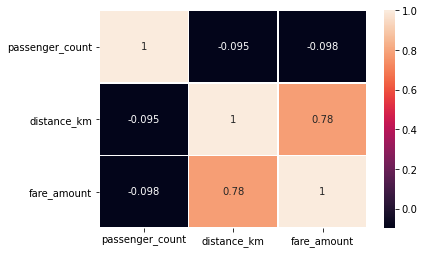

In [30]:
# Correlation
data_corr_train = filtered_train_set_with_IF.corr()
sns.heatmap(data_corr_train, linewidths=.5, annot=True)

### II. 4. Utilisation des quantiles pour supprimer les plus hautes et basses valeurs du dataset afin de l'alléger et réduire le nombre de valeurs disparates.

In [129]:
# filtered_train_set_with_IF['fare_amount'].plot(kind = 'box', title = 'Trips distribution according to their fare_amount', figsize = (10, 8))
# plt.show()

In [41]:
# Retrait des 10% de valeurs les plus hautes et 10% des valeurs les plus basses
train_set_final = filtered_train_set_with_IF[filtered_train_set_with_IF['fare_amount'].between(filtered_train_set_with_IF['fare_amount'].quantile(.10), filtered_train_set_with_IF['fare_amount'].quantile(.90))]

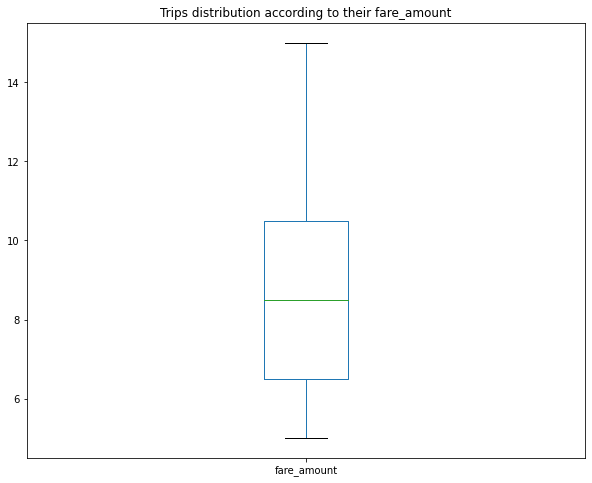

In [38]:
train_set_final['fare_amount'].plot(kind = 'box', title = 'Trips distribution according to their fare_amount', figsize = (10, 8))
plt.show()

<AxesSubplot:>

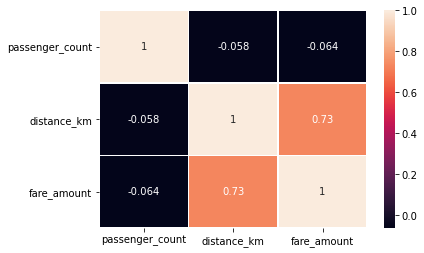

In [39]:
# Correlation
data_corr_train = train_set_final.corr()
sns.heatmap(data_corr_train, linewidths=.5, annot=True)

### II. 5. Mise en forme du dataset de test.

In [42]:
# Ajout colonne distance parcourue en Km avec la fonction compute_distance
test_set_final = test_set.assign(distance_km=fc.compute_distance(test_set['pickup_latitude'], test_set['pickup_longitude'], test_set['dropoff_latitude'], test_set['dropoff_longitude']))

# Sélection des colonnes qui intéressent
test_set_final = test_set_final[['passenger_count', 'distance_km']]

In [8]:
test_set_final.head()

,passenger_count,distance_km
0,1,2.323916
1,1,2.426038
2,1,6.059828
3,1,2.039587
4,1,5.312807


In [43]:
# Export en csv
test_set_final.to_csv(cr.CURATED_PATH + 'test_set_final.csv', index=False)
train_set_final.to_csv(cr.CURATED_PATH + 'train_set_final.csv', index=False)

## III. Prédiction du prix par XGBoost !

In [32]:
test_set_final = pd.read_csv(cr.CURATED_PATH + 'test_set_final.csv')
train_set_final = pd.read_csv(cr.CURATED_PATH + 'train_set_final.csv')

### III. 1. Split en x_train, y_train, x_test et y_test.

In [44]:
features = train_set_final[['passenger_count', 'distance_km']]
labels = train_set_final['fare_amount']

train_features, test_features, train_labels, test_labels = sklearn.model_selection.train_test_split(features, labels, test_size = 0.25, random_state = 1)

### III. 2. Création du modèle et prediction.

In [45]:
timer.start()
# Instanciation du modèle
xgb = Xgb_reg()
# Entrainnement du modèle
xgb.train(train_features, train_labels)
timer.stop()

Elapsed time: 14.8181 seconds


In [46]:
# Prédictions
xgb.predict(test_set_final)
test_set_final.head()

,passenger_count,distance_km,predicted_fare_amount
0,1,2.323916,6.326827
1,1,2.426038,6.405980
2,1,6.059828,7.916591
3,1,2.039587,6.036767
4,1,5.312807,7.916591


### III. 3. Vérification des metrics.

In [47]:
xgb.get_metrics(test_features, test_labels)

Mean squared error:  12.923804366639143 
Variance regression score function:  0.37465014518092166 
Maximum residual error:  10.142831802368164 
Mean absolute error regression loss:  2.914171651351828


## IV. Prédiction du prix par d'autres algorithmes

### IV. 1. SVR
Les Support Vector Machines (SVM) sont une classe d’algorithmes d’apprentissage initialement définis pour la prévision d’une variable
qualitative binaire puis généralisés à la prévision d’une variable quantitative. SVR joue sur la modélisation de plans vectoriels pour classer les données.

In [81]:
test_set_final = pd.read_csv(cr.CURATED_PATH + 'test_set_final.csv')

timer.start()

# Instanciation du modèle
svm = Svm_reg()
# Entrainnement du modèle
svm.train(train_features, train_labels)

timer.stop()

# Prédictions
svm.predict(test_set_final)
test_set_final.head()

Elapsed time: 86.5173 seconds
C:\Users\utilisateur\anaconda3\envs\data-science\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


,passenger_count,distance_km,predicted_fare_amount
0,1,2.323916,10.0
1,1,2.426038,10.0
2,1,6.059828,10.0
3,1,2.039587,10.0
4,1,5.312807,10.0


### IV. 2. LightGBM
Un modèle de boosting de gradient rapide et performant, dont l'apprentissage est basé sur un algorithme en arbre de décision. Il a l'avantage de réduire les pertes et apporter plus de précision aux résultats.

In [82]:
test_set_final = pd.read_csv(cr.CURATED_PATH + 'test_set_final.csv')

timer.start()

# Instanciation du modèle
lgbm = Lgbm_reg()
# Entrainnement du modèle
lgbm.train(train_features, train_labels)

timer.stop()

# Prédictions
lgbm.predict(test_set_final)
test_set_final.head()

Elapsed time: 2.1616 seconds


,passenger_count,distance_km,predicted_fare_amount
0,1,2.323916,9.585279
1,1,2.426038,9.758225
2,1,6.059828,13.058035
3,1,2.039587,9.032724
4,1,5.312807,12.981343


## V. Comparaison des algorithmes

In [80]:
print("------ XGBoost Metrics :")
xgb.get_metrics(test_features, test_labels)
print("***************************\n------ SVR Metrics :")
svm.get_metrics(test_features, test_labels)
print("***************************\n------ LightGBM Metrics :")
lgbm.get_metrics(test_features, test_labels)

------ XGBoost Metrics :
Mean squared error:  12.923804366639143 
Variance regression score function:  0.37465014518092166 
Maximum residual error:  10.142831802368164 
Mean absolute error regression loss:  2.914171651351828
***************************
------ SVR Metrics :
Mean squared error:  8.625347038510824 
Variance regression score function:  2.220446049250313e-16 
Maximum residual error:  5.000000000000048 
Mean absolute error regression loss:  2.5292345102448466
***************************
------ LightGBM Metrics :
Mean squared error:  3.160670807660884 
Variance regression score function:  0.5615223175089525 
Maximum residual error:  8.430606073041913 
Mean absolute error regression loss:  1.412963114257016
